#Task: DeepLense (Test 5)
#Author: Archil Srivastava

### Table of Contents
* [Imports](#imports)
* [Prepare Dataset](#prepare-dataset)
    * [Load Dataset](#load-dataset)
    * [Analyse Dataset](#analyse-dataset)
    * [Preprocess Dataset](#preprocess-dataset)
* [Training Pipeline](#train-pipeline)
* [Training](#training)
* [Evaluation](#evaluation)
    * [External Evaluation](#external-evaluation)
* [Acknowledgements](#acknowledgements)

<a name="imports"></a>
# Imports

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras.layers import (Layer, Input, Add, Flatten,
                          Dense, MultiHeadAttention, Embedding,
                          LayerNormalization, Dropout, LeakyReLU,
                          RandomFlip, RandomRotation, RandomZoom)
from PIL import Image
import numpy as np
import matplotlib.pyplot as plot

import os
import pdb

In [4]:
### Set Numpy Print Options ###
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [5]:
### Set random seed for reproducibility ###
SEED = 0
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [6]:
PERFORM_TRAINING = False # Set to False if only inference is to be done

<a name="prepare-dataset"></a>
# Prepare Dataset

<a name="load-dataset"></a>
### Load Dataset

In [7]:
# Unzip data
!tar zxf ./drive/MyDrive/test_5.tgz --transform s/lenses/data/

In [8]:
DATAPATH = './data' # Root path of data
OUTPATH = './output' # Storing output
os.makedirs(OUTPATH, exist_ok=True)
SAVEPATH = os.path.join(OUTPATH, 'weights') # For storing model weights
os.makedirs(SAVEPATH)
CKP_PATH = os.path.join(SAVEPATH, 'ckp')

CATEGORIES = ('no_sub', 'sub') # Labels: no_sub=0, sub=1

# Print directory structure
!tree --filelimit=10

.
├── data
│   ├── no_sub [5000 entries exceeds filelimit, not opening dir]
│   └── sub [5000 entries exceeds filelimit, not opening dir]
└── output
    └── weights

5 directories, 0 files


In [29]:
# Unzip model weights (if available)
!unzip -oq {os.path.join(OUTPATH, 'test_5_weights.zip')} -d {OUTPATH}

In [9]:
def load_data(root, categories):
    '''Loads examples and labels into numpy arrays'''
    x, y = [], []

    for index, category in enumerate(categories):
        for filename in os.scandir(os.path.join(root, category)):
            filedata = np.asarray(Image.open(filename.path))
            x.append(filedata)
            y.append(index) # Labels: no_sub=0, sub=1
  
    x = np.expand_dims(np.array(x), axis=-1) # add channel axis
    y = np.array(y)

    return x, y

In [10]:
X, Y = load_data(DATAPATH, CATEGORIES)

print(f'Shape of X: {X.shape}')
print(f'Shape of Y: {Y.shape}')

Shape of X: (10000, 150, 150, 1)
Shape of Y: (10000,)


In [11]:
# Shuffle train data
perm = np.random.permutation(len(X))
X, Y = X[perm], Y[perm]

# Train / Val split
val_size = len(X) // 10
X_TRAIN, Y_TRAIN = X[val_size:], Y[val_size:]
X_VAL, Y_VAL = X[:val_size], Y[:val_size]

print(f'X_TRAIN shape: {X_TRAIN.shape}')
print(f'X_VAL shape: {X_VAL.shape}')

X_TRAIN shape: (9000, 150, 150, 1)
X_VAL shape: (1000, 150, 150, 1)


<a name="analyse-dataset"></a>
### Analyse Dataset

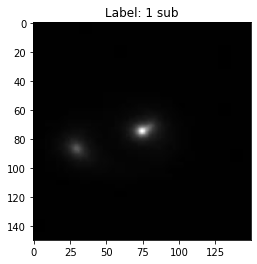

In [12]:
# Display random instance of data (This won't affect original SEED progression)
idx = np.random.default_rng().integers(0, len(X_TRAIN))
_ = plot.imshow(X_TRAIN[idx].squeeze(), cmap='gray')
_ = plot.title(f'Label: {Y_TRAIN[idx]} {CATEGORIES[Y_TRAIN[idx]]}')

In [13]:
# Check for class imbalance in train set
pos_neg_ratio = len(Y_TRAIN[Y_TRAIN == 1]) / len(Y_TRAIN[Y_TRAIN == 0])
print(f'Positive/Negative class ratio in train set: {pos_neg_ratio}')
if abs(pos_neg_ratio - 1) < 0.01:
    print('No class imbalance found.')
else:
    print('Class imbalance found!')

Positive/Negative class ratio in train set: 0.9933554817275747
No class imbalance found.


<a name="preprocess-dataset"></a>
### Preprocess Dataset

In [14]:
def standardize(x, datatype, root):
    '''Standardize image examples'''
    # Make image contrast similar across all images
    x = x - np.mean(x, axis=(1, 2), keepdims=True)
  
    if datatype == 'train':
        # Center around origin
        mean = np.mean(x, axis=(0, 1, 2), keepdims=True)
        std = np.std(x, axis=(0, 1, 2), keepdims=True)

        # Save mean and std for validation/test data
        np.save(os.path.join(root, 'mean'), mean)
        np.save(os.path.join(root, 'std'), std)
    else:
        try:
            mean = np.load(os.path.join(root, 'mean.npy'))
            std = np.load(os.path.join(root, 'std.npy'))
        except FileNotFoundError as _:
            raise FileNotFoundError('Standardizing info files (mean.npy and std.npy) not found')
  
    x = (x - mean) / std
    return x

In [15]:
### Preprocess data ###

# Standardize data
X_TRAIN = standardize(X_TRAIN, 'train', OUTPATH)
X_VAL = standardize(X_VAL, 'val', OUTPATH)

<a name="train-pipeline"></a>
# Training Pipeline

In [16]:
class Patches(Layer):
    '''
    Custom layer to split images into patches
    Input shape: (batch_size, image_size, image_size, channels)
    Output shape: (batch_size, num_patches, patch_size * patch_size * channels)
    '''
    def __init__(self, patch_size, num_channels=1, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.num_channels = num_channels

    def call(self, images, training=None):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, self.num_channels],
            strides=[1, self.patch_size, self.patch_size, self.num_channels],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patches = tf.reshape(patches,
                             [tf.shape(patches)[0], -1, tf.shape(patches)[-1]])
        return patches

In [17]:
class PatchEncoder(Layer):
    '''
    Custom Layer to encode patches and positions
    Input Shape: (batch_size, num_patches, patch_size * patch_size * channels)
    Output Shape: (batch_size, num_patches, projection_dim)
    '''
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches,
                                            output_dim=projection_dim)

    def call(self, patch, training=None):
        positions = tf.range(0, self.num_patches)
        # Add patch embeddings and position embeddings
        encoded = (self.projection(patch, training=training) +
                   self.position_embedding(positions, training=training))
        return encoded

In [18]:
class FFN(Layer):
    '''
    Custom Feedforward Network with dropout after every layer
    '''
    def __init__(self, hidden_units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.layers = [Dense(units, activation=tf.nn.gelu) for units in hidden_units]
        self.dropout_rate = dropout_rate
  
    def call(self, x, training=None):
        for layer in self.layers:
            x = layer(x, training=training)
            x = Dropout(self.dropout_rate)(x, training=training)
        return x

In [19]:
class Transformer(Layer):
    '''
    Transformer Block
    Input shape: (batch_size, num_patches, projection_dim)
    Output shape: (batch_size, num_patches, projection_dim)
    '''
    def __init__(self, transformer_units, num_heads, projection_dim,
                 epsilon=1e-6, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.norm1 = LayerNormalization(epsilon=epsilon)
        self.attention = MultiHeadAttention(num_heads=num_heads,
                                            key_dim=projection_dim,
                                            dropout=dropout_rate)
        self.norm2 = LayerNormalization(epsilon=epsilon)
        self.ffn = FFN(transformer_units, dropout_rate)
  
    def call(self, encoded_patch, training=None):
        x1 = self.norm1(encoded_patch, training=training)
        attention_output = self.attention(x1, x1, training=training)
        x2 = Add()([attention_output, encoded_patch])
        x3 = self.norm2(x2, training=training)
        x3 = self.ffn(x3, training=training)
        output = Add()([x3, x2])
        return output

In [20]:
class ViTClassifier(keras.Model):
    '''
    Classifier Model
    Input shape: (batch_size, image_size, image_size, num_channels)
    Output shape: (batch_size, 1)
    '''
    def __init__(self, patch_size, num_patches, projection_dim, mlp_head_units,
                 num_transformer_layers, transformer_units, num_heads,
                 dropout_rate=0.5, transformer_dropout_rate=0.1, epsilon=1e-6,
                 **kwargs):
        super().__init__(**kwargs)
        self.augment = keras.Sequential(
            [RandomFlip(),
             RandomRotation(0.5),
             RandomZoom(height_factor=0.2, width_factor=0.2)],
            name='augment'
        )

        self.patch = Patches(patch_size)
        self.patch_encoder = PatchEncoder(num_patches, projection_dim)
        self.transformers = keras.Sequential(
            [Transformer(transformer_units, num_heads, projection_dim,
                         epsilon=epsilon, dropout_rate=transformer_dropout_rate)
            for _ in range(num_transformer_layers)],
            name='transformers'
        )
        self.norm = LayerNormalization(epsilon=epsilon)
        self.dropout_rate = dropout_rate
        self.mlp_head = FFN(mlp_head_units, dropout_rate, name='mlp_head')
        self.classify = Dense(1, activation='sigmoid', name='classifier')
  
    def call(self, image, training=None):
        image = self.augment(image, training=training)

        # Patch encoding
        patches = self.patch(image, training=training)
        patches = self.patch_encoder(patches, training=training)

        # Transformer blocks
        patches = self.transformers(patches, training=training)

        # FeedForward Network
        representation = self.norm(patches, training=training)
        representation = Flatten()(representation)
        representation = Dropout(self.dropout_rate)(representation, training=training)
        representation = self.mlp_head(representation, training=training)
        output = self.classify(representation, training=training)

        return output

<a name="training"></a>
# Training

In [21]:
class RandomSampleGenerator(keras.utils.Sequence):
    '''
    Generates batches containing equal number of positive and negative examples
    to rectify any class imbalance in data
    '''
    def __init__(self, x, y, batch_size, seed=None):
        self.x_positive = x[y == 1]
        self.y_positive = y[y == 1]

        self.x_negative = x[y == 0]
        self.y_negative = y[y == 0]

        self.epoch_length = len(x) // batch_size
        self.batch_size = batch_size
        self.seed = seed
        self.reset()

    def reset(self):
        # Reset random number generator
        self.rng = np.random.default_rng(self.seed)

    def __len__(self):
        return self.epoch_length

    def __getitem__(self, idx):
        # Positive samples
        batch_positive_indices = self.rng.choice(self.x_positive.shape[0],
                                                 self.batch_size // 2,
                                                 replace=False)
        batch_x_positive = self.x_positive[batch_positive_indices]
        batch_y_positive = self.y_positive[batch_positive_indices]

        # Negative samples
        batch_negative_indices = self.rng.choice(self.x_negative.shape[0],
                                                 int(np.ceil(self.batch_size / 2)),
                                                 replace=False)
        batch_x_negative = self.x_negative[batch_negative_indices]
        batch_y_negative = self.y_negative[batch_negative_indices]

        # Concat both samples
        batch_x = np.concatenate((batch_x_positive, batch_x_negative))
        batch_y = np.concatenate((batch_y_positive, batch_y_negative))

        return batch_x, batch_y


In [22]:
class TrackBestPerformance(keras.callbacks.Callback):
    '''
    Callback to keep track of model weights which give best val_auc
    After training completes, the model is assigned with the best model weights
    '''
    def __init__(self, ckp_path, save_every=15, **kwargs):
        super().__init__(**kwargs)
        self.best_auc = 0
        self.best_epoch = -1
        self.best_weights = None
        self.ckp_path = ckp_path
        self.save_every = save_every
  
    def on_epoch_end(self, epoch, logs=None):
        '''Track best val_auc and corresponding weights'''
        current_auc = logs['val_auc']
        if current_auc >= self.best_auc:
            self.best_auc = current_auc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()
        if epoch % self.save_every == 0:
            self.model.save_weights(self.ckp_path)
  
    def on_train_end(self, logs=None):
        '''Reassign model weights to the one with the best val_auc'''
        self.model.set_weights(self.best_weights)
        self.model.save_weights(self.ckp_path)
        print(f'\nBest validation AUC is {self.best_auc} '
              f'on epoch #{self.best_epoch + 1}')


In [23]:
BATCH_SIZE = 256
EPOCHS = 200
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

IMAGE_SIZE = X_TRAIN.shape[1]
PATCH_SIZE = 15
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

PROJECTION_DIM = 64                                         # Dimensionality of patch encodings
NUM_HEADS=4                                                 # Number of heads in transformer

TRANSFORMER_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM]    # Dense layers in transformer block
NUM_TRANSFORMER_LAYERS = 8                                  # Number of transformer blocks
MLP_HEAD_UNITS = [2048, 1024]                               # Dense layers at the end of the network (after transformer layers)

# Pick a pre-saved model
USE_SAVED_MODEL = False

# Run eagerly for debugging
RUN_EAGERLY = False

In [24]:
# Instantiate new model
model = ViTClassifier(
    patch_size=PATCH_SIZE, num_patches=NUM_PATCHES,
    projection_dim=PROJECTION_DIM, mlp_head_units=MLP_HEAD_UNITS,
    num_transformer_layers=NUM_TRANSFORMER_LAYERS,
    transformer_units=TRANSFORMER_UNITS, num_heads=NUM_HEADS
)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tfa.optimizers.AdamW(learning_rate=LEARNING_RATE,
                                             weight_decay=WEIGHT_DECAY),
              metrics=keras.metrics.AUC(name='auc'),
              run_eagerly=RUN_EAGERLY)

if USE_SAVED_MODEL:
    # Pick a pre-trained model to finetune
    model.load_weights(CKP_PATH)

In [25]:
if PERFORM_TRAINING:
    train_generator = RandomSampleGenerator(X_TRAIN, Y_TRAIN, BATCH_SIZE, seed=SEED)
    callbacks = [TrackBestPerformance(CKP_PATH)]

    history = model.fit(train_generator, validation_data=(X_VAL, Y_VAL),
                        epochs=EPOCHS, callbacks=callbacks,
                        verbose=2)
else:
    model.load_weights(CKP_PATH)

Epoch 1/200
35/35 - 23s - loss: 1.4430 - auc: 0.5099 - val_loss: 0.6913 - val_auc: 0.5813 - 23s/epoch - 670ms/step
Epoch 2/200
35/35 - 9s - loss: 0.7312 - auc: 0.5169 - val_loss: 0.6913 - val_auc: 0.6071 - 9s/epoch - 266ms/step
Epoch 3/200
35/35 - 9s - loss: 0.7208 - auc: 0.5029 - val_loss: 0.6920 - val_auc: 0.5370 - 9s/epoch - 266ms/step
Epoch 4/200
35/35 - 9s - loss: 0.7028 - auc: 0.5281 - val_loss: 0.6909 - val_auc: 0.6380 - 9s/epoch - 269ms/step
Epoch 5/200
35/35 - 9s - loss: 0.7024 - auc: 0.5161 - val_loss: 0.6894 - val_auc: 0.6493 - 9s/epoch - 268ms/step
Epoch 6/200
35/35 - 9s - loss: 0.6974 - auc: 0.5349 - val_loss: 0.6851 - val_auc: 0.6707 - 9s/epoch - 269ms/step
Epoch 7/200
35/35 - 10s - loss: 0.6931 - auc: 0.5442 - val_loss: 0.6808 - val_auc: 0.6998 - 10s/epoch - 272ms/step
Epoch 8/200
35/35 - 9s - loss: 0.6868 - auc: 0.5616 - val_loss: 0.6683 - val_auc: 0.7447 - 9s/epoch - 271ms/step
Epoch 9/200
35/35 - 10s - loss: 0.6782 - auc: 0.5875 - val_loss: 0.6266 - val_auc: 0.7455 - 

In [26]:
if PERFORM_TRAINING:
    best_epoch_idx = np.argmax(history.history['val_auc'])

    print('Best validation AUC: {:.2%}'.format(history.history['val_auc'][best_epoch_idx]))
    print('Corresponding train AUC: {:.2%}'.format(history.history['auc'][best_epoch_idx]))

Best validation AUC: 99.97%
Corresponding train AUC: 99.19%


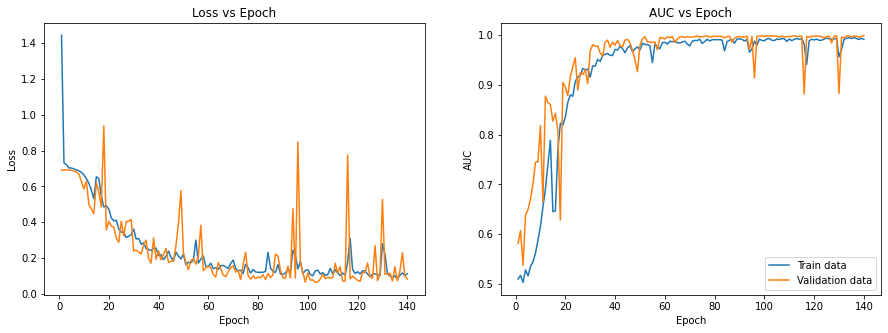

In [27]:
if PERFORM_TRAINING:
    _, axes = plot.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Loss vs Epoch plot
    _ = axes[0].plot(range(1, best_epoch_idx + 2),
                     history.history['loss'][:best_epoch_idx + 1],
                     label='Train data')
    _ = axes[0].plot(range(1, best_epoch_idx + 2),
                     history.history['val_loss'][:best_epoch_idx + 1],
                     label='Validation data')
    _ = axes[0].set(xlabel='Epoch', ylabel='Loss', title='Loss vs Epoch')

    # AUC vs Epoch plot
    _ = axes[1].plot(range(1, best_epoch_idx + 2),
                     history.history['auc'][:best_epoch_idx + 1],
                     label='Train data')
    _ = axes[1].plot(range(1, best_epoch_idx + 2),
                     history.history['val_auc'][:best_epoch_idx + 1],
                     label='Validation data')
    _ = axes[1].set(xlabel='Epoch', ylabel='AUC', title='AUC vs Epoch')

    _ = plot.legend()

In [28]:
# Zip model weights for download
!pushd {OUTPATH}; zip -rq test_5_weights.zip weights; popd

/content/output /content
/content


<a name="evaluation"><a/>
# Evaluation

In [29]:
def split_and_predict(x, num_batches=50):
    '''
    Utility function to do a forward pass with large data
    Splits data into batches and does forward pass through the model
    '''
    x_batches = np.array_split(x, num_batches)
    y_pred = np.concatenate([model(x_batch).numpy() for x_batch in x_batches], axis=0)[:, 0]
    return y_pred

In [30]:
# Get predictions (needed for plotting ROC curve)
Y_PRED_TRAIN = split_and_predict(X_TRAIN)
Y_PRED_VAL = split_and_predict(X_VAL)

In [31]:
def plot_roc_curve(y, y_pred, axis, label=None, num_thresholds=200):
    thresholds = np.linspace(0., 1., num_thresholds)

    tp, fp, tn, fn = [], [], [], []

    for threshold in thresholds:
        y_pred_label = (y_pred > threshold).astype(int)
        tp.append(np.count_nonzero(((y_pred_label == 1) & (y == 1)), axis=0))
        fp.append(np.count_nonzero(((y_pred_label == 1) & (y == 0)), axis=0))
        tn.append(np.count_nonzero(((y_pred_label == 0) & (y == 0)), axis=0))
        fn.append(np.count_nonzero(((y_pred_label == 0) & (y == 1)), axis=0))

    tp, fp, tn, fn = np.array(tp), np.array(fp), np.array(tn), np.array(fn)

    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)

    _ = axis.plot(fp_rate, tp_rate, label=label)

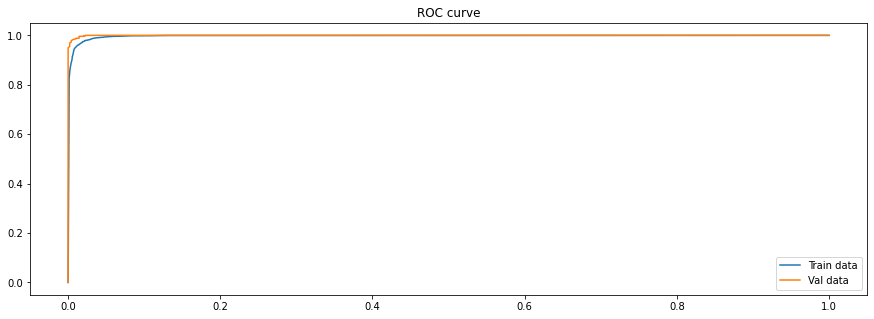

In [32]:
fig, axis = plot.subplots(figsize=(15, 5))

# ROC curve on train data
plot_roc_curve(Y_TRAIN, Y_PRED_TRAIN, axis, 'Train data')

# ROC curve on validation data
plot_roc_curve(Y_VAL, Y_PRED_VAL, axis, 'Val data')

_ = axis.set(title='ROC curve')
_ = plot.legend()

<a name="external-evaluation"><a/>
### External Evaluation

In [ ]:
# Load test data | Shape: (None, 150, 150, 1)
X_TEST, Y_TEST = None, None

In [ ]:
# Standardize test data
X_TEST = standardize(X_TEST, 'test', OUTPATH)

# Calculate AUC
test_auc = model.evaluate(X_TEST, Y_TEST, verbose=0)[1]

print(f'AUC on test data is {test_auc}')

In [ ]:
# Get predictions (needed to plot ROC curve)
Y_PRED_TEST = split_and_predict(X_TEST)

In [ ]:
# Plot ROC curve
fig, axis = plot.subplots(figsize=(15, 5))

# ROC curve on train data
plot_roc_curve(Y_TEST, Y_PRED_TEST, axis, 'Test data')

_ = axis.set(title='ROC curve')
_ = plot.legend()

<a name="acknowledgements"></a>

# Acknowledgements

The model ViTClassifier is partially inspired from https://keras.io/examples/vision/image_classification_with_vision_transformer/.